In [116]:
import requests  # API requests
import pandas as pd
import xml.etree.ElementTree as ET  # Will be used to parse the data
import matplotlib.pyplot as plt
import numpy as np


In [117]:
# Link to connect to the API
api_link = "http://reports.sem-o.com/api/v1/documents/static-reports"

In [118]:
def apiQuery(parameters):
    Response = requests.get(api_link, params=parameters)
    return Response

In [119]:
# Specifying our parameters
startDate = '2024-05-20'
endDate = '2024-06-20'
PageSize = '1'
SortBy = 'PublishTime'
ForecastReportName = 'Forecast Availability'
OutturnReportName = 'Average Outturn Availability'
ResourceName = ''
ParticipantName = 'PT_400116' #Viotas's name

# Getting the range of dates
dateRange = pd.date_range(start=startDate, end=endDate).date

In [120]:
# Function to filter XML strings from a JSON object
def filterXMLStrings(json_data):
    try:
        items = json_data.get('items', [])
        filtered_strings = [item['ResourceName'] for item in items if item['ResourceName'].endswith('.xml')]
        return filtered_strings
    except KeyError:
        print("KeyError: The JSON object does not contain the expected keys.")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []


In [121]:
# Function to loop through dates and return all the XML file names we need
def RetrieveXMLFileNames(XMLFileType):
    XMLFileNames = []
    for date in dateRange:
        TypeParameters = {
            'ReportName': XMLFileType,
            'Date': date,
            'page_size': PageSize,
            'sort_by': SortBy,
        }
        Response = apiQuery(TypeParameters)
        if Response.status_code != 200:
            print(f"Failed to retrieve data: {Response.status_code}")
        else:
            GridInfo = Response.json()

            # Filtering data to isolate the names of the XML files we want to use
            FilteredGridInfo = filterXMLStrings(GridInfo)
            XMLFileNames.extend(FilteredGridInfo)  # Extend instead of append

            #print("\n\n\n" + XMLFileType + ":", FilteredGridInfo)

    return XMLFileNames


In [122]:
ForecastResponseData = RetrieveXMLFileNames(ForecastReportName)
OutturnResponseData = RetrieveXMLFileNames(OutturnReportName)


def ResponseDataToDataFrame(ResponseData, Availability):
    print(ResponseData)

    availability_array = []
    data_array = []
    for data in ResponseData:
        url = 'https://reports.sem-o.com/documents/' + data
        df = pd.read_xml(url)
    
    if 'ParticipantName' in df.columns and Availability in df.columns:
            filtered_df = df[df['ParticipantName'] == ParticipantName]
            availability_array.extend(filtered_df[Availability].dropna().tolist())
            data_array.extend(filtered_df['StartTime'].dropna().tolist())

    data = {'Times': data_array, 'Availability': availability_array}
    df = pd.DataFrame(data=data)
    return df

Forecast = ResponseDataToDataFrame(ForecastResponseData, 'ForecastAvailability')
print(Forecast)
Outturn = ResponseDataToDataFrame(OutturnResponseData, 'AvgOutturnAvail')
print(Outturn)


['PUB_DailyForecastAvailability_202405192030.xml', 'PUB_DailyForecastAvailability_202405202030.xml', 'PUB_DailyForecastAvailability_202405212030.xml', 'PUB_DailyForecastAvailability_202405222030.xml', 'PUB_DailyForecastAvailability_202405232030.xml', 'PUB_DailyForecastAvailability_202405242030.xml', 'PUB_DailyForecastAvailability_202405252030.xml', 'PUB_DailyForecastAvailability_202405262030.xml', 'PUB_DailyForecastAvailability_202405272030.xml', 'PUB_DailyForecastAvailability_202405282030.xml', 'PUB_DailyForecastAvailability_202405292030.xml', 'PUB_DailyForecastAvailability_202405302030.xml', 'PUB_DailyForecastAvailability_202405312030.xml', 'PUB_DailyForecastAvailability_202406012030.xml', 'PUB_DailyForecastAvailability_202406022030.xml', 'PUB_DailyForecastAvailability_202406032030.xml', 'PUB_DailyForecastAvailability_202406042030.xml', 'PUB_DailyForecastAvailability_202406052030.xml', 'PUB_DailyForecastAvailability_202406062030.xml', 'PUB_DailyForecastAvailability_202406072030.xml',

forecast                   Times  Availability
0   2024-06-19T22:00:00      4.681818
1   2024-06-19T22:30:00      4.681818
2   2024-06-19T23:00:00      4.545455
3   2024-06-19T23:30:00      4.545455
4   2024-06-20T00:00:00      4.636364
5   2024-06-20T00:30:00      4.636364
6   2024-06-20T01:00:00      4.681818
7   2024-06-20T01:30:00      4.681818
8   2024-06-20T02:00:00      4.409091
9   2024-06-20T02:30:00      4.409091
10  2024-06-20T03:00:00      4.590909
11  2024-06-20T03:30:00      4.590909
12  2024-06-20T04:00:00      4.227273
13  2024-06-20T04:30:00      4.227273
14  2024-06-20T05:00:00      4.545455
15  2024-06-20T05:30:00      4.545455
16  2024-06-20T06:00:00      4.454545
17  2024-06-20T06:30:00      4.454545
18  2024-06-20T07:00:00      4.636364
19  2024-06-20T07:30:00      4.636364
20  2024-06-20T08:00:00      4.636364
21  2024-06-20T08:30:00      4.636364
22  2024-06-20T09:00:00      4.636364
23  2024-06-20T09:30:00      4.636364
24  2024-06-20T10:00:00      4.636364
25 

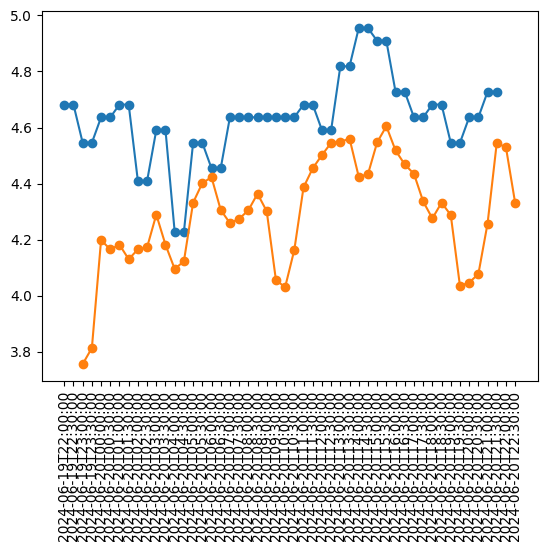

In [127]:
#Averaging inputs with the same date so we only have one y for every x value
Forecast=Forecast.groupby('Times').mean().reset_index() 
Outturn=Outturn.groupby('Times').mean().reset_index()

plt.plot( Forecast['Times'],Forecast['Availability'])
plt.plot( Outturn['Times'],Outturn['Availability'])
plt.xticks(rotation = 90)
plt.scatter(Forecast['Times'],Forecast['Availability'])
plt.scatter(Outturn['Times'],Outturn['Availability'])

print("forecast",Forecast)
print("Outturn",Outturn)